# Calculating Return on Investment for Hot Spots Policing

By [Andrew Wheeler, PhD](mailto:apwheele@gmail.com) 
Website: [andrewpwheeler.com](https://andrewpwheeler.com/)

So we want to go from the Cohen's D measures in the [Braga hot spot meta-analysis](https://www.tandfonline.com/doi/abs/10.1080/07418825.2012.673632), to a measure more directly related to how much crime is reduced. What I want to do in the end is to recreate the pre and post counts of crime, so I can estimate the direct crime reduction effect of the number of crime reduced.

First, the Cohen's D measure for these interventions is calculated as:

$$ D = \log(OR) \cdot \sqrt{ 3/\pi } $$

Where $OR$ is the odds ratio. The odds ratio is calculated from the pre-post counts of crime table. 

|         | Pre   | Post  |
|---------|-------|-------|
| Treated | $t_0$ | $t_1$ |
| Control | $c_0$ | $c_1$ |

The odds ratio is calculated as:

$$ OR = \frac{t_1/t_0}{c_1/c_0} $$

So we have a few unknowns here to back calculate a return on investment for a particular crime intervention. First, the baseline of crime makes a big difference. Using the typical interpretation of the $OR$ as a percent reduction, say we have a 10% decline (i.e. an $OR = 0.9$). If we start with a baseline of 100 crimes, that is a net reduction of 10 crimes ($100 - OR \cdot 100 = 10$). But if we start with a baseline of 10 crimes, it is only a reduction of 1 crime ($10 - OR \cdot 10 = 1$). So those are big differences! The ROI is tied directly to the baseline crime counts. 

Second, this is ignoring the control areas. For simplicity in this analysis, first I am going to assume the control areas do not change, so $c_1 = c_0$. This then reduces the odds ratio formula to simply $OR = t_1/t_0$. Second, I assume that $t_0 = c_0 = c_1$. This is basically saying that the control areas had the same numbers of crime to the treated area at baseline. 

So the formula then to go from the Cohen's D estimates in the Braga meta-analysis to an estimate of $t_1$ and $t_0$ would be:

$$ \exp( \frac{D}{\sqrt{3/\pi}} ) = OR = t_1/t_0 $$ 

So subsquently if I want to calculate $t_1 - t_0 = \Delta t$, if we fix $t_0$ to some arbitrary value, we then have:

$$ OR \cdot t_0 = t_1 $$

So then:

$$ \Delta t = OR \cdot t_0 - t_0 $$

What I do below is based on the overall Cohen's D effect size, I plot $\Delta t$ given a fixed value of $t_0$. Note that the Braga meta-analysis gives the estimates where D is positive (but signifies a reduction in crime). So I actually take the negative of the Cohen's D value. 

meta analysis D of -0.184 to odds ratio of 0.828


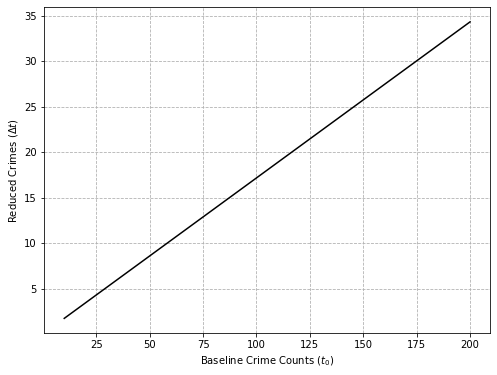

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

def d_to_or(d):
    return math.exp( d / math.sqrt(3/math.pi) )

#overall meta analysis estimate of D
big_D = -0.184

#So about a 15% decline
meta_or = d_to_or(big_D)
print( "meta analysis D of {:1.3f} to odds ratio of {:1.3f}".format(big_D, meta_or) )

#plot over a range of 10 to 200
baseline = np.arange(10,201)
reduction = baseline - baseline*meta_or #This is the positive reduction in crimes

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(baseline,reduction, color='k')
ax.set_xlabel('Baseline Crime Counts ($t_0$)')
ax.set_ylabel('Reduced Crimes ($\Delta t$)')
ax.grid(True,linestyle='--')
plt.show()

So that was alot of work just to figure out a percent reduction estimate!

So what I do now is take the specific estimates from Braga's meta-analysis (Table 3), for the overall effects for violent and property crimes. Then I take the cost of law-enforcement estimates from this [Hunt paper](https://www.cambridge.org/core/journals/journal-of-benefit-cost-analysis/article/estimates-of-law-enforcement-costs-by-crime-type-for-benefitcost-analyses/0A1A55F70324FDBAA947FF1F18AA1B74). Those are costs directly related to law enforcement, like how much time it takes to investigate/respond to crime. Finally, I grab the biggest hot spot in my current working paper on [cost of crime hot spots](https://osf.io/preprints/socarxiv/nmq8r/), and get an ROI estimate conditional on the total number of crimes in the hot spot. (In particular it is hot spot 59, the largest in the [center of this map](https://apwheele.github.io/MathPosts/HotSpotMap.html).)

In [2]:
#Now lets go through an example for one of my hot spot areas
#https://apwheele.github.io/MathPosts/HotSpotMap.html
#Choosing the biggest area, ID 59 in the center of map

#Taken from Braga's Table 3
or_v = d_to_or(-0.175)
or_p = d_to_or(-0.084)

#Hot spot 59 and cost of crime estimates for Texas from Hunt paper
dat = [('v','Murder',124353,0),
       ('v','Assault',8292,130),
       ('v','Robbery',2229,38),
       ('p','Burglary',1185,29),
       ('p','Theft',1024,212),
       ('p','Veh Theft',769,51)]

hs_59 = pd.DataFrame(dat, columns=['Type','Crime','Cost','TotalCrime'])
hs_59['OR'] = or_v
hs_59.loc[ hs_59['Type'] == 'p', 'OR'] = or_p
hs_59['CrimeReduction'] = hs_59['TotalCrime'] - hs_59['TotalCrime']*hs_59['OR']
hs_59['ROI'] = hs_59['CrimeReduction']*hs_59['Cost']

print( "Total estimated crime reduction ROI for hot spot 59: ${:,.0f}".format( hs_59['ROI'].sum() ))

var_order = ['Crime','Cost','TotalCrime','CrimeReduction','ROI']
hs_59[var_order]

Total estimated crime reduction ROI for hot spot 59: $214,576


,Crime,Cost,TotalCrime,CrimeReduction,ROI
0,Murder,124353,0,0.000000,0.000000
1,Assault,8292,130,21.315165,176745.344043
2,Robbery,2229,38,6.230587,13887.977412
3,Burglary,1185,29,2.388688,2830.595344
4,Theft,1024,212,17.462133,17881.224561
5,Veh Theft,769,51,4.200796,3230.412303


Some caveats to this of course. One, you can always do a poor job on a hot spots intervention (so the lower bound of ROI is a negative number). Doing planning on the overall effect size though seems reasonable on its face to me. (So your banking on being as effective as the average hot spots experiment.) I wouldn't assume offhand you are going to be more effective than this, at least to justify an intervention from a cost-benefit perspective.

This also averages together all different crimes, which may not be reasonable given the intervention. For example, one of the most successful hot spots experiments was the [Kansas City gun experiment](https://www.tandfonline.com/doi/abs/10.1080/07418829500096241). An intervention like that may not be reasonable to extrapolate to all crimes. So if the Dallas PD wanted to do something like that, it would probably only make sense to look at the relevant violent crimes, not all of the crimes (so only look at a specific row of the above table).

These estimates are the 'credits' of conducting a hot spots policing strategy, not the 'debits' of officer time. So if what you want to do costs way more than the ROI in that area (like pay a ton of overtime to officers), it seems hot spots policing is potentially not worth the effort.

These ROI estimates are also for 1.5 years of data, and the long term effectiveness of hot spots policing has not been established. So that means these estimates are not 'you do this hot spots thing for a short time period crime goes down forever', they are 'if you continue to do this hot spots thing, you should see reduced crimes around this margin'.

So for this, if you wanted to create a POP officer for just this one hot spot, that ends up being a return of around $150k per year. So that seems to justify that single position. Smaller hot spots will need to be more along the lines of shifting current resources, as oppossed to creating new positions.